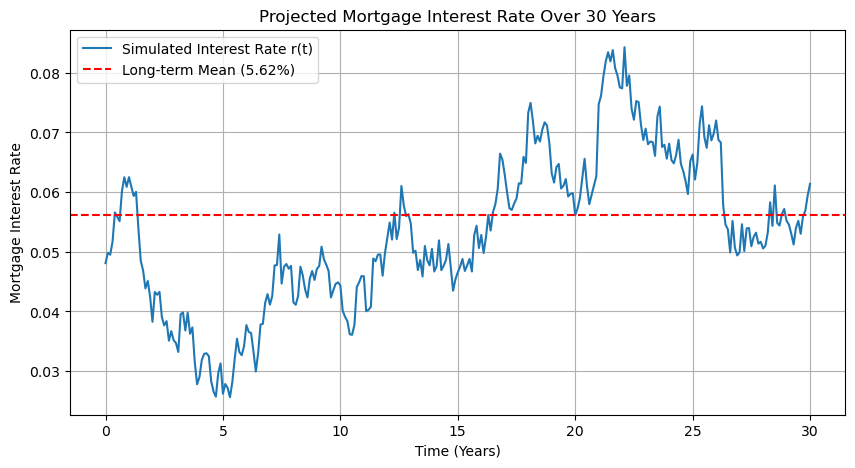

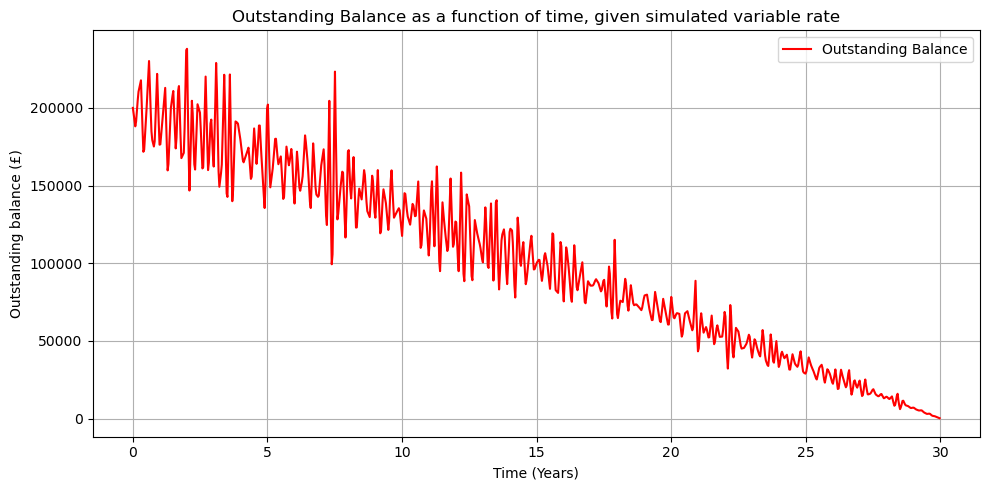

In [27]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
from scipy.integrate import cumtrapz

# params for Ornstein-Uhlenbeck
mu = 0.0562      # Long-term mean interest rate
theta = 0.2    # mean reversion
sigma = 0.01   # volatility
r0 = 0.0481    # Initial rate
T = 30         
dt = 0.1       

t = sp.Symbol('t')

t_vals = np.arange(0, T + dt, dt)
n_steps = len(t_vals)

#simulate Ornstein-Uhlenbeck process
np.random.seed(42) 
a_vals = np.zeros(n_steps)
a_vals[0] = r0

for i in range(1, n_steps):
    dW = np.sqrt(dt) * np.random.randn() # random element
    a_vals[i] = a_vals[i-1] + theta * (mu - a_vals[i-1]) * dt + sigma * dW

a_function = interp1d(t_vals, a_vals, kind='cubic', fill_value="extrapolate")
afunc_vals = a_function(t_vals)

# spline representation for r(t)
spline = UnivariateSpline(t_vals, a_vals, k=3, s=0) 
R = spline.antiderivative()

alpha_int_callable = R

cubic_spline = CubicSpline(t_vals, r_vals, bc_type='natural')

spline_exprs = []
for i in range(len(t_vals) - 1):
    t_i = t_vals[i]
    a_i, b_i, c_i, d_i = map(sp.S, cubic_spline.c[:, i])

    poly_expr = (
        a_i + b_i * (t - t_i) + c_i * (t - t_i)**2 + d_i * (t - t_i)**3
    )

    condition = sp.And(t >= t_i, t < t_vals[i+1])  # Ensure SymPy logical expression
    spline_exprs.append((poly_expr, condition))

#piecewise function
rSym = sp.Piecewise(*spline_exprs)

#symbolic integral
RSym = sp.integrate(rSym, t)

alpha_int = RSym

plt.figure(figsize=(10, 5))
plt.plot(t_vals, rfunc_vals, label="Simulated Interest Rate r(t)")
plt.axhline(y=mu, color='r', linestyle='--', label="Long-term Mean (5.62%)")
plt.xlabel("Time (Years)")
plt.ylabel("Mortgage Interest Rate")
plt.title("Projected Mortgage Interest Rate Over 30 Years")
plt.legend()
plt.grid()
plt.show()

B0 = 200000

t = sp.Symbol('t')
B_0, T_T = sp.symbols('B_0, T_T')

def rCalc(t):
    return (B0/T) * np.exp(alpha_int_callable(t))

rSym = (B_0/T_T) * sp.exp(alpha_int)

BSym = sp.exp(alpha_int) * (B_0 - sp.integrate(rSym * sp.exp(-1 * alpha_int), t))

BNum = sp.lambdify((t, B_0, T_T), BSym, 'numpy')

T_array = np.linspace(0, 30, 1000)

r_Vals = rCalc(T_array)
B_Vals = BNum(T_array, B0, T)

#print(B_Vals)
plt.figure(figsize=(10, 5))
plt.plot(T_array, B_Vals, color='r', label="Outstanding Balance")

# Adding labels and title
plt.xlabel('Time (Years)')
plt.ylabel('Outstanding balance (£)')
plt.title('Outstanding Balance as a function of time, given simulated variable rate')
plt.legend()

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.savefig('Outstanding Balance as a function of time for simulated variable rate.jpg')
plt.show()

